# Bella Lui 3-DOF vs 6-DOF Flight Simulation Comparison

This notebook demonstrates the differences between the 3-DOF and 6-DOF simulation modes using the Bella Lui rocket from EPFL Rocket Team. It compares the trajectory, apogee, and other flight parameters between both simulation modes, including the effect of the weathercocking model on 3-DOF simulations.

**Permission to use flight data given by Antoine Scardigli, 2020**

## Overview

The 3-DOF simulation mode with the weathercocking model allows for:
- Faster simulations compared to 6-DOF
- Evolving attitude that aligns with the relative wind direction
- Configurable alignment rate via the `weathercock_coeff` parameter

This example compares:
1. **6-DOF**: Full rotational and translational dynamics (reference)
2. **3-DOF (wc=0)**: Fixed attitude, no quaternion evolution
3. **3-DOF (wc=1)**: Default weathercocking, moderate alignment rate
4. **3-DOF (wc=5)**: High weathercocking, faster alignment rate

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from rocketpy import Environment, Flight, Function, Rocket, SolidMotor
from rocketpy.motors.point_mass_motor import PointMassMotor
from rocketpy.rocket.point_mass_rocket import PointMassRocket

## Define Bella Lui Rocket Parameters

In [2]:
parameters = {
    # Mass Details
    "rocket_mass": (18.227 - 1, 0.010),  # 1.373 = propellant mass
    # propulsion details
    "impulse": (2157, 0.03 * 2157),
    "burn_time": (2.43, 0.1),
    "nozzle_radius": (44.45 / 1000, 0.001),
    "throat_radius": (21.4376 / 1000, 0.001),
    "grain_separation": (3 / 1000, 1 / 1000),
    "grain_density": (782.4, 30),
    "grain_outer_radius": (85.598 / 2000, 0.001),
    "grain_initial_inner_radius": (33.147 / 1000, 0.002),
    "grain_initial_height": (152.4 / 1000, 0.001),
    # Aerodynamic Details
    "inertia_i": (0.78267, 0.03 * 0.78267),
    "inertia_z": (0.064244, 0.03 * 0.064244),
    "radius": (156 / 2000, 0.001),
    "distance_rocket_nozzle": (-1.1356, 0.100),
    "distance_rocket_propellant": (-1, 0.100),
    "power_off_drag": (1, 0.05),
    "power_on_drag": (1, 0.05),
    "nose_length": (0.242, 0.001),
    "nose_distance_to_cm": (1.3, 0.100),
    "fin_span": (0.200, 0.001),
    "fin_root_chord": (0.280, 0.001),
    "fin_tip_chord": (0.125, 0.001),
    "fin_distance_to_cm": (-0.75, 0.100),
    "tail_top_radius": (156 / 2000, 0.001),
    "tail_bottom_radius": (135 / 2000, 0.001),
    "tail_length": (0.050, 0.001),
    "tail_distance_to_cm": (-1.0856, 0.001),
    # Launch and Environment Details
    "wind_direction": (0, 5),
    "wind_speed": (1, 0.05),
    "inclination": (89, 1),
    "heading": (45, 5),
    "rail_length": (4.2, 0.001),
    # Parachute Details
    "CdS_drogue": (np.pi / 4, 0.20 * np.pi / 4),
    "lag_rec": (1, 0.020),
}

## Create Environment

Set up the environment for the Bella Lui mission at Kaltbrunn, Switzerland.


Gravity Details

Acceleration of gravity at surface level:    9.8100 m/s²
Acceleration of gravity at   2.000 km (ASL): 9.8100 m/s²


Launch Site Details

Launch Date: 2020-02-22 13:00:00 UTC
Launch Site Latitude: 47.21348°
Launch Site Longitude: 9.00334°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 500252.61 E    5228887.37 N
Launch Site UTM zone: 32T
Launch Site Surface Elevation: 407.0 m


Atmospheric Model Details

Atmospheric Model Type: Reanalysis
Reanalysis Maximum Height: 2.000 km
Reanalysis Time Period: from 2020-02-22 00:00:00 to 2020-02-22 18:00:00 utc
Reanalysis Hour Interval: 4 hrs
Reanalysis Latitude Range: From 48.0° to 46.0°
Reanalysis Longitude Range: From 8.0° to 10.0°

Surface Atmospheric Conditions

Surface Wind Speed: 1.26 m/s
Surface Wind Direction: 213.21°
Surface Wind Heading: 33.21°
Surface Pressure: 980.43 hPa
Surface Temperature: 286.63 K
Surface Air Density: 1.192 kg/m³
Surface Speed of Sound: 339.39 m/s


Earth Model Details

Earth Radius at Lau

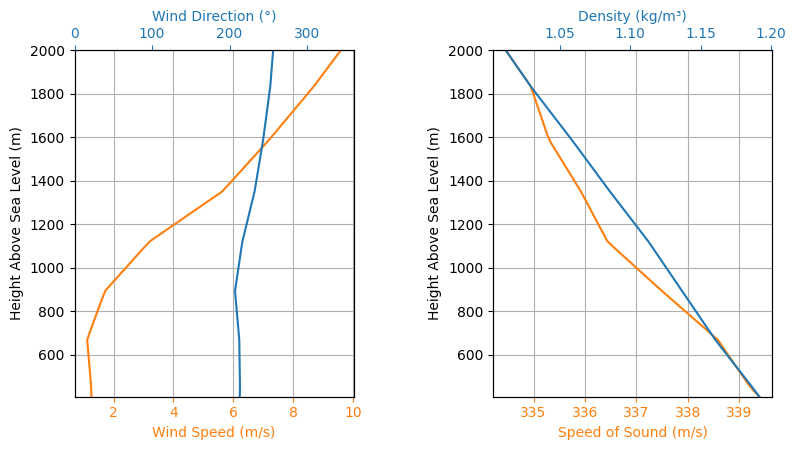

In [3]:
env = Environment(
    gravity=9.81,
    latitude=47.213476,
    longitude=9.003336,
    date=(2020, 2, 22, 13),
    elevation=407,
)
env.set_atmospheric_model(
    type="Reanalysis",
    file="../../data/weather/bella_lui_weather_data_ERA5.nc",
    dictionary="ECMWF",
)
env.max_expected_height = 2000
env.info()

## Create Motor

Create the AeroTech K828FJ solid motor.

Nozzle Details
Nozzle Radius: 0.04445 m
Nozzle Throat Radius: 0.0214376 m

Grain Details
Number of Grains: 3
Grain Spacing: 0.003 m
Grain Density: 782.4 kg/m3
Grain Outer Radius: 0.042799 m
Grain Inner Radius: 0.033146999999999996 m
Grain Height: 0.1524 m
Grain Volume: 0.000 m3
Grain Mass: 0.275 kg

Motor Details
Total Burning Time: 2.43 s
Total Propellant Mass: 0.824 kg
Structural Mass Ratio: 0.548
Average Propellant Exhaust Velocity: 2514.035 m/s
Average Thrust: 852.260 N
Maximum Thrust: 1303.79 N at 0.04 s after ignition.
Total Impulse: 2070.992 Ns



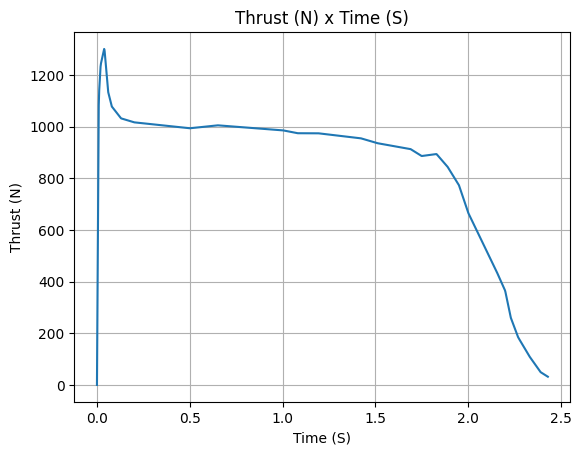

In [4]:
motor = SolidMotor(
    thrust_source="../../data/motors/aerotech/AeroTech_K828FJ.eng",
    burn_time=parameters.get("burn_time")[0],
    dry_mass=1,
    dry_inertia=(0, 0, 0),
    center_of_dry_mass_position=0,
    grains_center_of_mass_position=parameters.get("distance_rocket_propellant")[0],
    grain_number=3,
    grain_separation=parameters.get("grain_separation")[0],
    grain_density=parameters.get("grain_density")[0],
    grain_outer_radius=parameters.get("grain_outer_radius")[0],
    grain_initial_inner_radius=parameters.get("grain_initial_inner_radius")[0],
    grain_initial_height=parameters.get("grain_initial_height")[0],
    nozzle_radius=parameters.get("nozzle_radius")[0],
    throat_radius=parameters.get("throat_radius")[0],
    interpolation_method="linear",
    nozzle_position=parameters.get("distance_rocket_nozzle")[0],
)
motor.info()

## Create Rocket

Create the Bella Lui rocket with aerodynamic surfaces.

In [5]:
bella_lui = Rocket(
    radius=parameters.get("radius")[0],
    mass=parameters.get("rocket_mass")[0],
    inertia=(
        parameters.get("inertia_i")[0],
        parameters.get("inertia_i")[0],
        parameters.get("inertia_z")[0],
    ),
    power_off_drag=0.43,
    power_on_drag=0.43,
    center_of_mass_without_motor=0,
)
bella_lui.set_rail_buttons(0.1, -0.5)
bella_lui.add_motor(motor, parameters.get("distance_rocket_nozzle")[0])
bella_lui.add_nose(
    length=parameters.get("nose_length")[0],
    kind="tangent",
    position=parameters.get("nose_distance_to_cm")[0]
    + parameters.get("nose_length")[0],
)
bella_lui.add_trapezoidal_fins(
    3,
    span=parameters.get("fin_span")[0],
    root_chord=parameters.get("fin_root_chord")[0],
    tip_chord=parameters.get("fin_tip_chord")[0],
    position=parameters.get("fin_distance_to_cm")[0],
)
bella_lui.add_tail(
    top_radius=parameters.get("tail_top_radius")[0],
    bottom_radius=parameters.get("tail_bottom_radius")[0],
    length=parameters.get("tail_length")[0],
    position=parameters.get("tail_distance_to_cm")[0],
)

# Define aerodynamic drag coefficients
bella_lui.power_off_drag = Function(
    [
        (0.01, 0.51),
        (0.02, 0.46),
        (0.04, 0.43),
        (0.28, 0.43),
        (0.29, 0.44),
        (0.45, 0.44),
        (0.49, 0.46),
    ],
    "Mach Number",
    "Drag Coefficient with Power Off",
    "linear",
    "constant",
)
bella_lui.power_on_drag = Function(
    [
        (0.01, 0.51),
        (0.02, 0.46),
        (0.04, 0.43),
        (0.28, 0.43),
        (0.29, 0.44),
        (0.45, 0.44),
        (0.49, 0.46),
    ],
    "Mach Number",
    "Drag Coefficient with Power On",
    "linear",
    "constant",
)
bella_lui.power_off_drag *= parameters.get("power_off_drag")[0]
bella_lui.power_on_drag *= parameters.get("power_on_drag")[0]

bella_lui.info()


# Add parachute for landing
def drogue_trigger(p, h, y):
    # Deploy drogue when vertical velocity is negative (descending)
    return True if y[5] < 0 else False


bella_lui.add_parachute(
    name="Drogue",
    cd_s=np.pi / 4,  # CdS = pi/4 m²
    trigger=drogue_trigger,
    sampling_rate=105,
    lag=1.0,
)


Inertia Details

Rocket Mass: 17.227 kg (without motor)
Rocket Dry Mass: 18.227 kg (with unloaded motor)
Rocket Loaded Mass: 19.051 kg
Rocket Structural Mass Ratio: 0.957
Rocket Inertia (with unloaded motor) 11: 2.002 kg*m2
Rocket Inertia (with unloaded motor) 22: 2.002 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.064 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.078 m
Rocket Frontal Area: 0.019113 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.062 m
Rocket Center of Dry Mass - Nozzle Exit: 2.209 m
Rocket Center of Dry Mass - Center of Propellant Mass: 2.073 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.090 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 10.281/rad
Tail Lift Coefficient De

<Parachute Drogue (cd_s = 0.7854 m2, trigger = <function drogue_trigger at 0x7f938f23d440>)>

## Create Point Mass Rocket for 3-DOF Simulations

For 3-DOF simulations, we use `PointMassRocket` and `PointMassMotor` which are simplified models that don't require full inertia and aerodynamic surface definitions.

In [6]:
# Create a PointMassMotor with similar characteristics to the K828FJ
point_mass_motor = PointMassMotor(
    thrust_source="../../data/motors/aerotech/AeroTech_K828FJ.eng",
    dry_mass=1.0,
    propellant_initial_mass=1.373,  # propellant mass
)

# Create a PointMassRocket with similar properties to Bella Lui
point_mass_rocket = PointMassRocket(
    radius=parameters.get("radius")[0],
    mass=parameters.get("rocket_mass")[0],
    center_of_mass_without_motor=0,
    power_off_drag=0.43,
    power_on_drag=0.43,
)
point_mass_rocket.add_motor(
    point_mass_motor, parameters.get("distance_rocket_nozzle")[0]
)

print(f"Point Mass Rocket mass (without motor): {point_mass_rocket.mass} kg")
print(f"Point Mass Rocket radius: {point_mass_rocket.radius} m")


# Add parachute for landing (same as 6-DOF)
def drogue_trigger_3dof(p, h, y):
    # Deploy drogue when vertical velocity is negative (descending)
    return True if y[5] < 0 else False


point_mass_rocket.add_parachute(
    name="Drogue",
    cd_s=np.pi / 4,  # CdS = pi/4 m²
    trigger=drogue_trigger_3dof,
    sampling_rate=105,
    lag=1.0,
)

Point Mass Rocket mass (without motor): 17.227 kg
Point Mass Rocket radius: 0.078 m


<Parachute Drogue (cd_s = 0.7854 m2, trigger = <function drogue_trigger_3dof at 0x7f938f27fba0>)>

## Run Flight Simulations

Now we run four different flight simulations to compare 6-DOF and 3-DOF modes with different weathercocking coefficients.

### 6-DOF Flight Simulation (Reference)

This is the full 6-DOF simulation that serves as our reference.

In [7]:
import time

start_time = time.time()
flight_6dof = Flight(
    rocket=bella_lui,
    environment=env,
    rail_length=parameters.get("rail_length")[0],
    inclination=parameters.get("inclination")[0],
    heading=parameters.get("heading")[0],
    terminate_on_apogee=False,
)
time_6dof = time.time() - start_time

print(f"6-DOF Apogee: {flight_6dof.apogee - env.elevation:.2f} m AGL")
print(f"6-DOF Apogee Time: {flight_6dof.apogee_time:.2f} s")
print(f"6-DOF Simulation Runtime: {time_6dof:.3f} s")

6-DOF Apogee: 460.91 m AGL
6-DOF Apogee Time: 10.61 s
6-DOF Simulation Runtime: 0.250 s


### 3-DOF Flight (No Weathercocking, wc=0)

Using `PointMassRocket` and `PointMassMotor` for the 3-DOF simulation with fixed attitude mode.

In [8]:
start_time = time.time()
flight_3dof_fixed = Flight(
    rocket=point_mass_rocket,
    environment=env,
    rail_length=parameters.get("rail_length")[0],
    inclination=parameters.get("inclination")[0],
    heading=parameters.get("heading")[0],
    terminate_on_apogee=False,
    simulation_mode="3 DOF",
    weathercock_coeff=0.0,
)
time_3dof_fixed = time.time() - start_time

print(f"3-DOF (wc=0) Apogee: {flight_3dof_fixed.apogee - env.elevation:.2f} m AGL")
print(f"3-DOF (wc=0) Apogee Time: {flight_3dof_fixed.apogee_time:.2f} s")
print(f"3-DOF (wc=0) Simulation Runtime: {time_3dof_fixed:.3f} s")

3-DOF (wc=0) Apogee: 448.24 m AGL
3-DOF (wc=0) Apogee Time: 10.49 s
3-DOF (wc=0) Simulation Runtime: 0.035 s


### 3-DOF Flight (Default Weathercocking, wc=1)

Using `PointMassRocket` and `PointMassMotor` with default weathercocking - moderate alignment toward the relative wind.

In [9]:
start_time = time.time()
flight_3dof_wc1 = Flight(
    rocket=point_mass_rocket,
    environment=env,
    rail_length=parameters.get("rail_length")[0],
    inclination=parameters.get("inclination")[0],
    heading=parameters.get("heading")[0],
    terminate_on_apogee=False,
    simulation_mode="3 DOF",
    weathercock_coeff=1.0,
)
time_3dof_wc1 = time.time() - start_time

print(f"3-DOF (wc=1) Apogee: {flight_3dof_wc1.apogee - env.elevation:.2f} m AGL")
print(f"3-DOF (wc=1) Apogee Time: {flight_3dof_wc1.apogee_time:.2f} s")
print(f"3-DOF (wc=1) Simulation Runtime: {time_3dof_wc1:.3f} s")

3-DOF (wc=1) Apogee: 447.90 m AGL
3-DOF (wc=1) Apogee Time: 10.49 s
3-DOF (wc=1) Simulation Runtime: 0.050 s


### 3-DOF Flight (High Weathercocking, wc=5)

Using `PointMassRocket` and `PointMassMotor` with high weathercocking - faster alignment toward the relative wind.

In [10]:
start_time = time.time()
flight_3dof_wc5 = Flight(
    rocket=point_mass_rocket,
    environment=env,
    rail_length=parameters.get("rail_length")[0],
    inclination=parameters.get("inclination")[0],
    heading=parameters.get("heading")[0],
    terminate_on_apogee=False,
    simulation_mode="3 DOF",
    weathercock_coeff=5.0,
)
time_3dof_wc5 = time.time() - start_time

print(f"3-DOF (wc=5) Apogee: {flight_3dof_wc5.apogee - env.elevation:.2f} m AGL")
print(f"3-DOF (wc=5) Apogee Time: {flight_3dof_wc5.apogee_time:.2f} s")
print(f"3-DOF (wc=5) Simulation Runtime: {time_3dof_wc5:.3f} s")

3-DOF (wc=5) Apogee: 447.61 m AGL
3-DOF (wc=5) Apogee Time: 10.48 s
3-DOF (wc=5) Simulation Runtime: 0.056 s


## Results Comparison

### Summary Table

In [11]:
print("=" * 80)
print("SIMULATION RESULTS COMPARISON")
print("=" * 80)

print(
    "\n{:<40} {:>10} {:>10} {:>10} {:>10}".format(
        "Parameter", "6-DOF", "3DOF(wc=0)", "3DOF(wc=1)", "3DOF(wc=5)"
    )
)
print("-" * 80)

print(
    "{:<40} {:>10.2f} {:>10.2f} {:>10.2f} {:>10.2f}".format(
        "Apogee (m AGL)",
        flight_6dof.apogee - env.elevation,
        flight_3dof_fixed.apogee - env.elevation,
        flight_3dof_wc1.apogee - env.elevation,
        flight_3dof_wc5.apogee - env.elevation,
    )
)

print(
    "{:<40} {:>10.2f} {:>10.2f} {:>10.2f} {:>10.2f}".format(
        "Apogee Time (s)",
        flight_6dof.apogee_time,
        flight_3dof_fixed.apogee_time,
        flight_3dof_wc1.apogee_time,
        flight_3dof_wc5.apogee_time,
    )
)

print(
    "{:<40} {:>10.2f} {:>10.2f} {:>10.2f} {:>10.2f}".format(
        "Max Speed (m/s)",
        flight_6dof.max_speed,
        flight_3dof_fixed.max_speed,
        flight_3dof_wc1.max_speed,
        flight_3dof_wc5.max_speed,
    )
)

# Max acceleration only available for 6-DOF with parachute descent
print(
    "{:<40} {:>10.2f} {:>10} {:>10} {:>10}".format(
        "Max Acceleration (m/s²)",
        flight_6dof.max_acceleration,
        "N/A",
        "N/A",
        "N/A",
    )
)
print("  (Note: Max acceleration not yet available for 3-DOF with parachute)")

print(
    "{:<40} {:>10.2f} {:>10.2f} {:>10.2f} {:>10.2f}".format(
        "Impact X (m)",
        flight_6dof.x_impact,
        flight_3dof_fixed.x_impact,
        flight_3dof_wc1.x_impact,
        flight_3dof_wc5.x_impact,
    )
)

print(
    "{:<40} {:>10.2f} {:>10.2f} {:>10.2f} {:>10.2f}".format(
        "Impact Y (m)",
        flight_6dof.y_impact,
        flight_3dof_fixed.y_impact,
        flight_3dof_wc1.y_impact,
        flight_3dof_wc5.y_impact,
    )
)

print(
    "{:<40} {:>10.3f} {:>10.3f} {:>10.3f} {:>10.3f}".format(
        "Simulation Runtime (s)",
        time_6dof,
        time_3dof_fixed,
        time_3dof_wc1,
        time_3dof_wc5,
    )
)

# Performance comparison
print("\n" + "-" * 80)
print("PERFORMANCE COMPARISON:")
print("-" * 80)

speedup_fixed = time_6dof / time_3dof_fixed if time_3dof_fixed > 0 else 0
speedup_wc1 = time_6dof / time_3dof_wc1 if time_3dof_wc1 > 0 else 0
speedup_wc5 = time_6dof / time_3dof_wc5 if time_3dof_wc5 > 0 else 0

print(
    "{:<40} {:>10} {:>10.1f}x {:>10.1f}x {:>10.1f}x".format(
        "Speedup vs 6-DOF", "-", speedup_fixed, speedup_wc1, speedup_wc5
    )
)

# Percentage differences
print("\n" + "-" * 80)
print("PERCENTAGE DIFFERENCE FROM 6-DOF REFERENCE:")
print("-" * 80)

apogee_diff_fixed = (
    (flight_3dof_fixed.apogee - flight_6dof.apogee) / flight_6dof.apogee * 100
)
apogee_diff_wc1 = (
    (flight_3dof_wc1.apogee - flight_6dof.apogee) / flight_6dof.apogee * 100
)
apogee_diff_wc5 = (
    (flight_3dof_wc5.apogee - flight_6dof.apogee) / flight_6dof.apogee * 100
)

print(
    "{:<40} {:>10} {:>10.2f}% {:>10.2f}% {:>10.2f}%".format(
        "Apogee Difference", "-", apogee_diff_fixed, apogee_diff_wc1, apogee_diff_wc5
    )
)

SIMULATION RESULTS COMPARISON

Parameter                                     6-DOF 3DOF(wc=0) 3DOF(wc=1) 3DOF(wc=5)
--------------------------------------------------------------------------------
Apogee (m AGL)                               460.91     448.24     447.90     447.61
Apogee Time (s)                               10.61      10.49      10.49      10.48
Max Speed (m/s)                               86.24      84.78      84.72      84.71


Max Acceleration (m/s²)                       58.47        N/A        N/A        N/A
  (Note: Max acceleration not yet available for 3-DOF with parachute)
Impact X (m)                                   5.95      30.32      18.82       2.45
Impact Y (m)                                   1.62      38.52      20.74      -4.76
Simulation Runtime (s)                        0.250      0.035      0.050      0.056

--------------------------------------------------------------------------------
PERFORMANCE COMPARISON:
--------------------------------------------------------------------------------
Speedup vs 6-DOF                                  -        7.1x        5.0x        4.4x

--------------------------------------------------------------------------------
PERCENTAGE DIFFERENCE FROM 6-DOF REFERENCE:
--------------------------------------------------------------------------------
Apogee Difference                                 -      -1.46%      -1.50%      -1.53%


## Comparison Plots

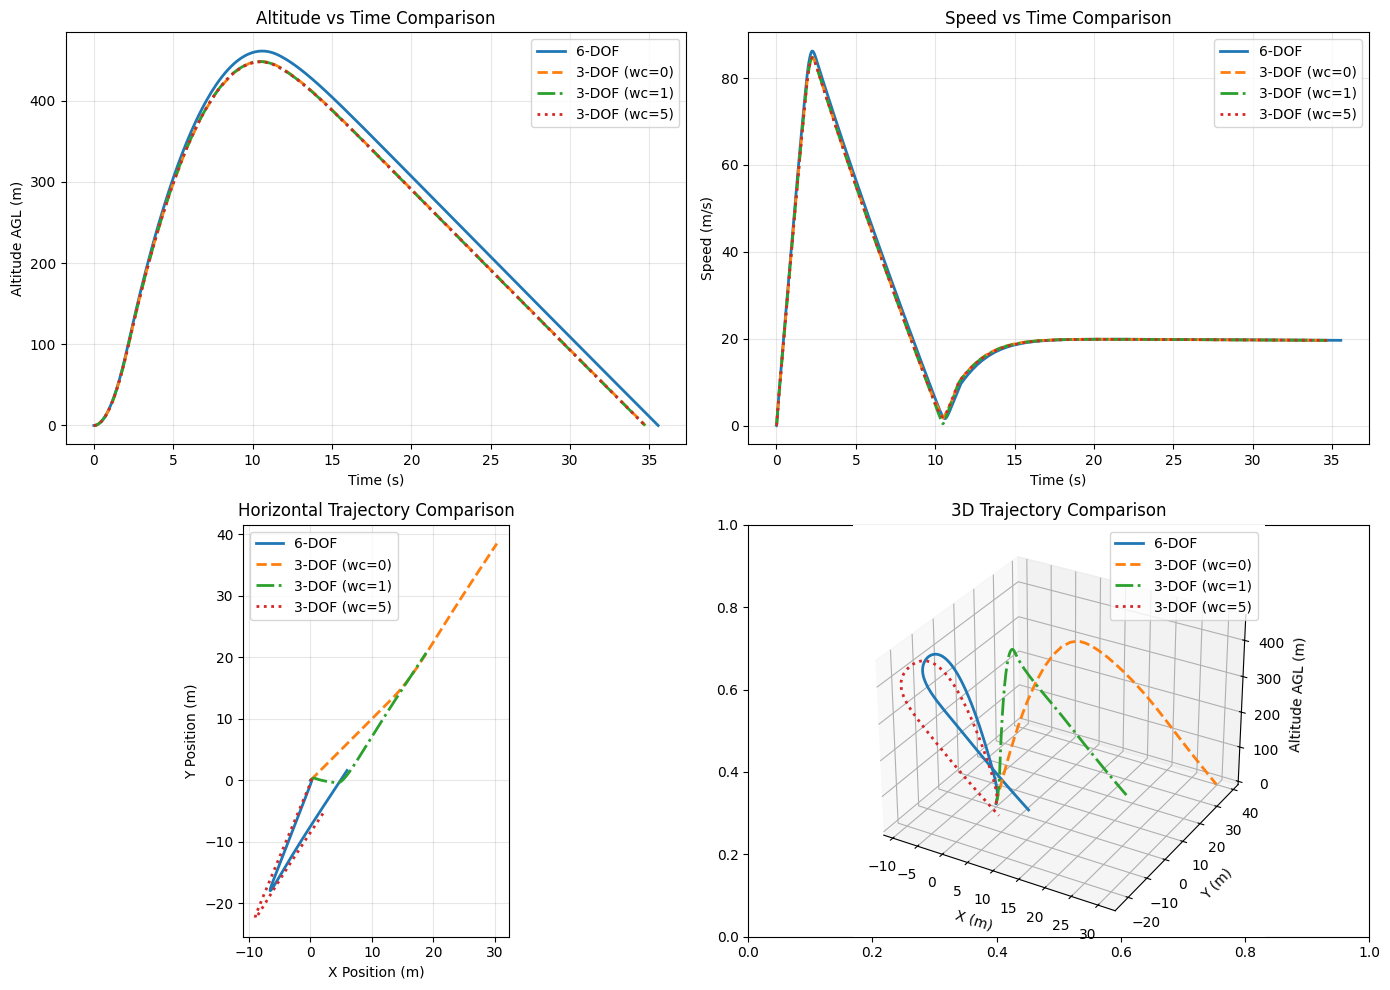

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Altitude vs Time
ax1 = axes[0, 0]
ax1.plot(
    flight_6dof.z[:, 0], flight_6dof.z[:, 1] - env.elevation, label="6-DOF", linewidth=2
)
ax1.plot(
    flight_3dof_fixed.z[:, 0],
    flight_3dof_fixed.z[:, 1] - env.elevation,
    label="3-DOF (wc=0)",
    linestyle="--",
    linewidth=2,
)
ax1.plot(
    flight_3dof_wc1.z[:, 0],
    flight_3dof_wc1.z[:, 1] - env.elevation,
    label="3-DOF (wc=1)",
    linestyle="-.",
    linewidth=2,
)
ax1.plot(
    flight_3dof_wc5.z[:, 0],
    flight_3dof_wc5.z[:, 1] - env.elevation,
    label="3-DOF (wc=5)",
    linestyle=":",
    linewidth=2,
)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Altitude AGL (m)")
ax1.set_title("Altitude vs Time Comparison")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Speed vs Time
ax2 = axes[0, 1]
ax2.plot(flight_6dof.speed[:, 0], flight_6dof.speed[:, 1], label="6-DOF", linewidth=2)
ax2.plot(
    flight_3dof_fixed.speed[:, 0],
    flight_3dof_fixed.speed[:, 1],
    label="3-DOF (wc=0)",
    linestyle="--",
    linewidth=2,
)
ax2.plot(
    flight_3dof_wc1.speed[:, 0],
    flight_3dof_wc1.speed[:, 1],
    label="3-DOF (wc=1)",
    linestyle="-.",
    linewidth=2,
)
ax2.plot(
    flight_3dof_wc5.speed[:, 0],
    flight_3dof_wc5.speed[:, 1],
    label="3-DOF (wc=5)",
    linestyle=":",
    linewidth=2,
)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_title("Speed vs Time Comparison")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Horizontal Trajectory (X-Y)
ax3 = axes[1, 0]
ax3.plot(flight_6dof.x[:, 1], flight_6dof.y[:, 1], label="6-DOF", linewidth=2)
ax3.plot(
    flight_3dof_fixed.x[:, 1],
    flight_3dof_fixed.y[:, 1],
    label="3-DOF (wc=0)",
    linestyle="--",
    linewidth=2,
)
ax3.plot(
    flight_3dof_wc1.x[:, 1],
    flight_3dof_wc1.y[:, 1],
    label="3-DOF (wc=1)",
    linestyle="-.",
    linewidth=2,
)
ax3.plot(
    flight_3dof_wc5.x[:, 1],
    flight_3dof_wc5.y[:, 1],
    label="3-DOF (wc=5)",
    linestyle=":",
    linewidth=2,
)
ax3.set_xlabel("X Position (m)")
ax3.set_ylabel("Y Position (m)")
ax3.set_title("Horizontal Trajectory Comparison")
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_aspect("equal")

# Plot 4: 3D Trajectory
ax4 = fig.add_subplot(2, 2, 4, projection="3d")
ax4.plot(
    flight_6dof.x[:, 1],
    flight_6dof.y[:, 1],
    flight_6dof.z[:, 1] - env.elevation,
    label="6-DOF",
    linewidth=2,
)
ax4.plot(
    flight_3dof_fixed.x[:, 1],
    flight_3dof_fixed.y[:, 1],
    flight_3dof_fixed.z[:, 1] - env.elevation,
    label="3-DOF (wc=0)",
    linestyle="--",
    linewidth=2,
)
ax4.plot(
    flight_3dof_wc1.x[:, 1],
    flight_3dof_wc1.y[:, 1],
    flight_3dof_wc1.z[:, 1] - env.elevation,
    label="3-DOF (wc=1)",
    linestyle="-.",
    linewidth=2,
)
ax4.plot(
    flight_3dof_wc5.x[:, 1],
    flight_3dof_wc5.y[:, 1],
    flight_3dof_wc5.z[:, 1] - env.elevation,
    label="3-DOF (wc=5)",
    linestyle=":",
    linewidth=2,
)
ax4.set_xlabel("X (m)")
ax4.set_ylabel("Y (m)")
ax4.set_zlabel("Altitude AGL (m)")
ax4.set_title("3D Trajectory Comparison")
ax4.legend()

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrates the differences between 6-DOF and 3-DOF simulation modes:

### Simulation Modes

1. **6-DOF (Full Dynamics)**:
   - Full rotational and translational dynamics
   - Quaternions evolve based on angular momentum conservation
   - Most accurate but computationally expensive

2. **3-DOF with weathercock_coeff=0 (Fixed Attitude)**:
   - Only translational dynamics
   - Attitude remains fixed (no quaternion evolution)
   - Fastest but may not capture lateral motion accurately

3. **3-DOF with weathercock_coeff=1 (Default Weathercocking)**:
   - Translational dynamics with quasi-static attitude evolution
   - Body axis aligns toward relative wind direction
   - Good balance between accuracy and speed

4. **3-DOF with weathercock_coeff=5 (High Weathercocking)**:
   - Faster alignment toward relative wind
   - Useful when rocket is expected to quickly align with velocity

### Key Observations

- The weathercocking model helps the 3-DOF simulation better approximate the 6-DOF behavior by allowing the attitude to evolve
- Higher `weathercock_coeff` values result in faster alignment with the wind
- The 3-DOF mode is significantly faster and suitable for Monte Carlo simulations where many runs are needed